# Machine Learning 

In [4]:
!pip install xgboost
!pip install shap
!pip install deap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import PercentFormatter 

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

import xgboost as xgb
import shap

from deap import base, creator, tools, algorithms
import random

## Step 1. Data Clearning and Exploratory Data Analysis 

### 1.1 Data Cleaning 

In [5]:
df = pd.read_csv("default of credit card clients.csv", header=1)  # skip first row
df.rename(columns={"default payment next month": "default"}, inplace=True)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.shape

(30000, 25)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [8]:
#Summary Stastistic 
df.describe(include ="all")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### Credit Info
LIMIT_BAL (Credit Limit): Mean: 167k, Min: 10k, Max: 1M  
Big range → some users have very high credit. Needs scaling.  

#### Demographics
SEX: 1 = Male, 2 = Female → fair split (mean ~1.6)  
EDUCATION: Range 0–6, but mostly 1–4  
MARRIAGE: Mostly 1–2 (married/single)
AGE: Avg: 35 years, Range: 21–79  

#### Repayment Status (PAY_0 to PAY_6)  
Range: -2 to 8  
-2 = pay early; 0 = on time; >0 = late (months)  
 
#### Bill Amounts (BILL_AMT1 to BILL_AMT6)    
Range: Negative to ~900k NT$

#### Payment Amounts (PAY_AMT1 to PAY_AMT6)  
Range: 0 to 873k NT$

#### Target Variable: default  
Mean: 0.22 → 22% of users defaulted


In [10]:
education_list = df['EDUCATION'].unique().tolist()
print("Education List:", sorted(education_list))

Education List: [0, 1, 2, 3, 4, 5, 6]


In [11]:
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})  # 4 = others

In [12]:
marriage_list = df['MARRIAGE'].unique().tolist()
print("Marriage List:", sorted(marriage_list))

Marriage List: [0, 1, 2, 3]


In [13]:
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})  # 3 = others

In [14]:
age_list = df['AGE'].unique().tolist()
print("Age List:", sorted(age_list))

Age List: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79]


In [15]:
feature_descriptions = {
    'X1': 'Amount of the given credit (NT dollar): includes both individual and family (supplementary) credit.',
    'X2': 'Gender (1 = male; 2 = female).',
    'X3': 'Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).',
    'X4': 'Marital status (1 = married; 2 = single; 3 = others).',
    'X5': 'Age of the client in years.',
    
    'X6': 'Repayment status in September 2005 (-1 = pay duly; 1 = 1-month delay; ...; 9 = 9+ months delay).',
    'X7': 'Repayment status in August 2005.',
    'X8': 'Repayment status in July 2005.',
    'X9': 'Repayment status in June 2005.',
    'X10': 'Repayment status in May 2005.',
    'X11': 'Repayment status in April 2005.',
    
    'X12': 'Amount of bill statement in September 2005 (NT dollar).',
    'X13': 'Amount of bill statement in August 2005.',
    'X14': 'Amount of bill statement in July 2005.',
    'X15': 'Amount of bill statement in June 2005.',
    'X16': 'Amount of bill statement in May 2005.',
    'X17': 'Amount of bill statement in April 2005.',
    
    'X18': 'Amount paid in September 2005 (NT dollar).',
    'X19': 'Amount paid in August 2005.',
    'X20': 'Amount paid in July 2005.',
    'X21': 'Amount paid in June 2005.',
    'X22': 'Amount paid in May 2005.',
    'X23': 'Amount paid in April 2005.',
    
    'Y': 'Target variable: whether the client defaulted on payment next month (1 = Yes, 0 = No).'
}

for feature, description in feature_descriptions.items():
    print(f"{feature}: {description}")

X1: Amount of the given credit (NT dollar): includes both individual and family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age of the client in years.
X6: Repayment status in September 2005 (-1 = pay duly; 1 = 1-month delay; ...; 9 = 9+ months delay).
X7: Repayment status in August 2005.
X8: Repayment status in July 2005.
X9: Repayment status in June 2005.
X10: Repayment status in May 2005.
X11: Repayment status in April 2005.
X12: Amount of bill statement in September 2005 (NT dollar).
X13: Amount of bill statement in August 2005.
X14: Amount of bill statement in July 2005.
X15: Amount of bill statement in June 2005.
X16: Amount of bill statement in May 2005.
X17: Amount of bill statement in April 2005.
X18: Amount paid in September 2005 (NT dollar).
X19: Amount paid in August 2005.
X20: Amount paid in July 2005.
X21: Amount pa

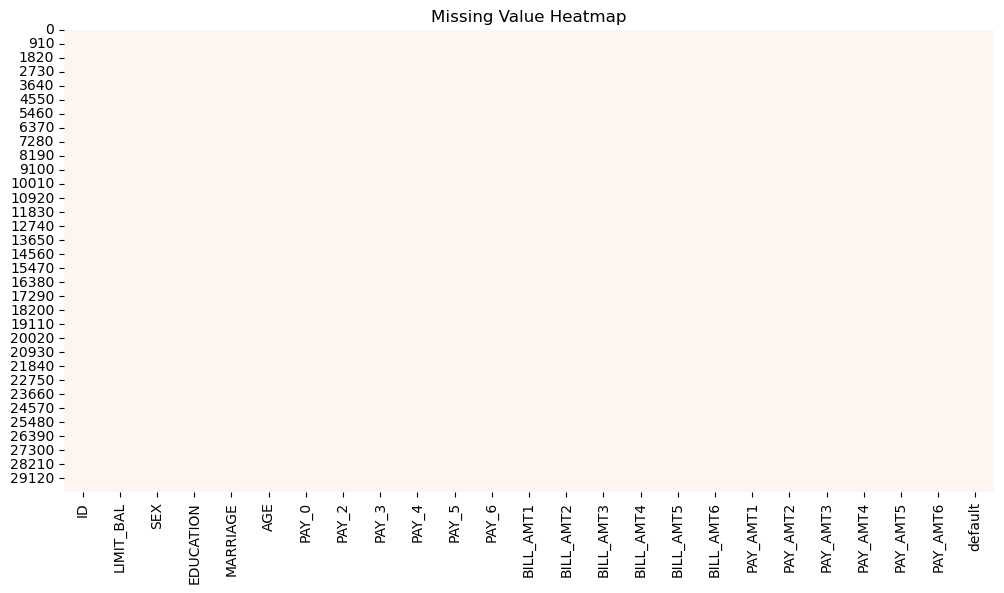

In [16]:
#Missing Values
missing_values = df.isna().sum()

# Missing value Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
plt.title("Missing Value Heatmap")
plt.show()

#### No missing values found 

In [18]:
#Duplicate Values 
df.duplicated().sum()

0

#### No Duplicate value existed 

### 1.2 Exploratory Data Analysis 

In [21]:
# Correlation Matrix
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,1.000000,0.026179,0.018497,0.037659,-0.028208,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,...,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,-0.231088,-0.111012,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.013627,-0.028522,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,0.037659,-0.231088,0.013627,1.000000,-0.136797,0.182434,0.112593,0.129703,0.122425,0.116531,...,-0.006131,-0.012439,-0.012646,-0.041088,-0.032793,-0.044293,-0.040949,-0.045138,-0.044061,0.033842
MARRIAGE,-0.028208,-0.111012,-0.028522,-0.136797,1.000000,-0.412001,0.018557,0.023620,0.032399,0.031831,...,-0.027274,-0.029270,-0.025066,-0.004653,-0.009513,-0.004250,-0.013970,-0.003019,-0.008383,-0.027575
AGE,0.018678,0.144713,-0.090874,0.182434,-0.412001,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.030575,-0.271214,-0.057643,0.112593,0.018557,-0.039447,1.000000,0.672164,0.574245,0.538841,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,0.129703,0.023620,-0.050148,0.672164,1.000000,0.766552,0.662067,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,0.122425,0.032399,-0.053048,0.574245,0.766552,1.000000,0.777359,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.002735,-0.267460,-0.060173,0.116531,0.031831,-0.049722,0.538841,0.662067,0.777359,1.000000,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614


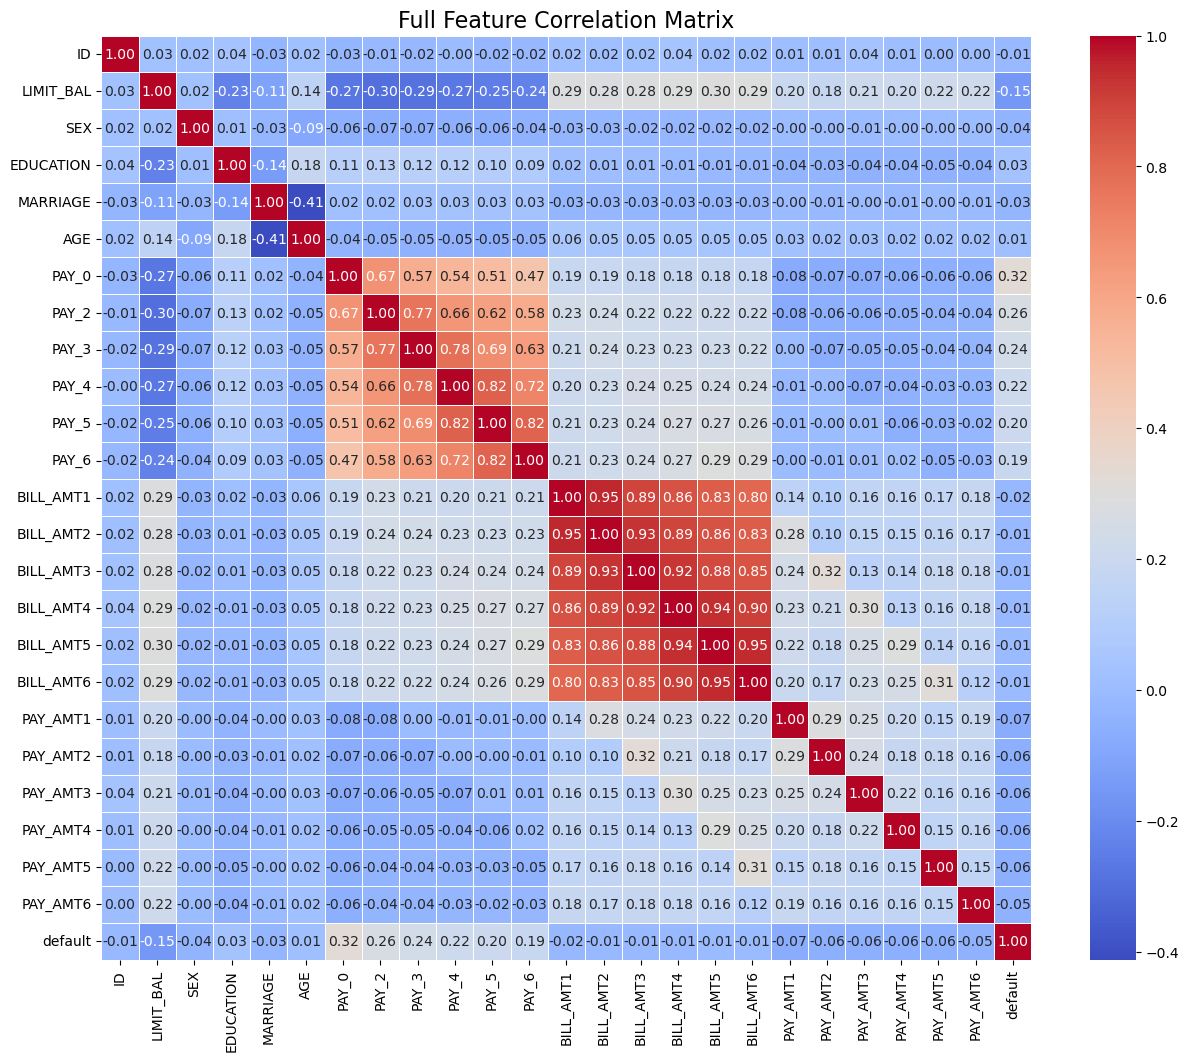

In [22]:
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Full Feature Correlation Matrix", fontsize=16)
plt.show()

#### 1. Strongest Correlation with Default
PAY_0 (current payment status) → 0.32  
PAY_2, PAY_3, ..., PAY_6 → all positively correlated (~0.18–0.26)  
Late payments are the most predictive of default.

#### 2. LIMIT_BAL (Credit Limit)  
Correlation with default = -0.15  
 Higher credit limits slightly reduce default risk.  

#### 3. Bill Amounts Correlate With Each Other  
BILL_AMT1 to BILL_AMT6 are very strongly correlated (0.8–0.95)  
People tend to carry similar monthly balances.   
Likely redundant → could reduce dimensionality (PCA or feature selection).

#### 4. Payment Amounts (PAY_AMT)
Weak correlation with default (~-0.05 to -0.07)
Paying more helps, but it's not a strong predictor by itself.

#### 5. Demographics (SEX, EDUCATION, MARRIAGE)
Very weak correlations (close to 0)
May add small value combined with other features but not useful alone.

#### Summary  
Default is most correlated with past payment delays (PAY_0–PAY_6).  
Bill amounts are highly related to each other, and credit limit has a small protective effect.   
Payment amounts and demographics have low predictive power individually.  

In [24]:
# Correlation with Target Variable
correlation_with_target = correlation_matrix["default"].sort_values(ascending=False)
print("\nCorrelation with Target Variable:\n", correlation_with_target)


Correlation with Target Variable:
 default      1.000000
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.033842
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
BILL_AMT4   -0.010156
ID          -0.013952
BILL_AMT3   -0.014076
BILL_AMT2   -0.014193
BILL_AMT1   -0.019644
MARRIAGE    -0.027575
SEX         -0.039961
PAY_AMT6    -0.053183
PAY_AMT5    -0.055124
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT2    -0.058579
PAY_AMT1    -0.072929
LIMIT_BAL   -0.153520
Name: default, dtype: float64


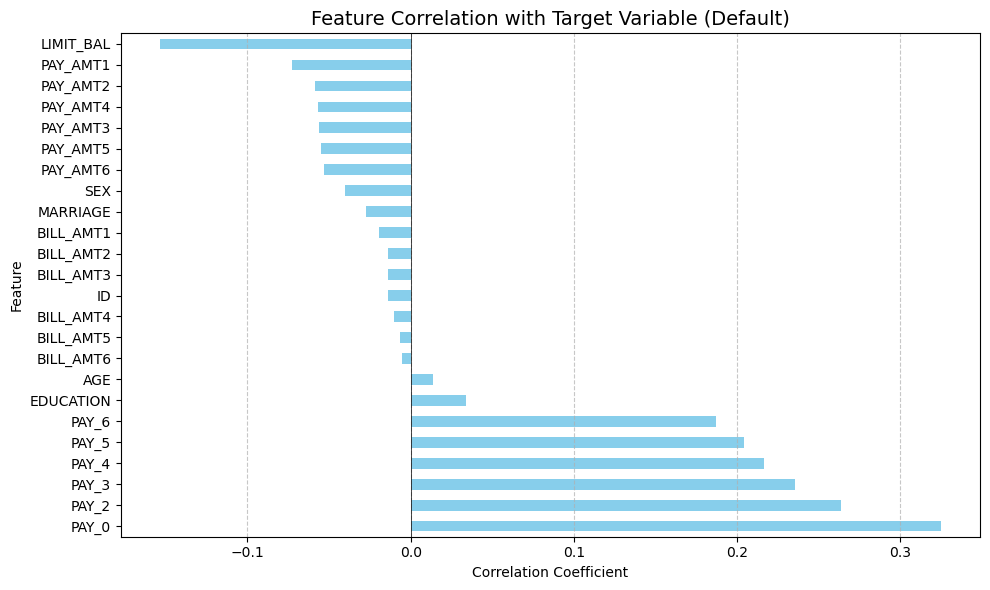

In [25]:
plt.figure(figsize=(10, 6))
correlation_with_target.drop("default").plot(kind="barh", color="skyblue")
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Feature Correlation with Target Variable (Default)", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Top Positive Correlations (more likely to default):
PAY_0 (0.32) – most recent repayment delay  
PAY_2 to PAY_6 – earlier months' delay history   
Main signal: people who have delayed payments recently or consistently are much more likely to default.

#### Top Negative Correlations (less likely to default):
LIMIT_BAL (-0.15) → Higher credit limits = lower risk  
PAY_AMT1–6 (~-0.05 to -0.07) → Paying more = slightly less likely to default  
Paying more and having more credit is associated with lower default risk.  

#### Weak or No Correlation:
SEX, MARRIAGE, AGE, EDUCATION, BILL_AMT  
Demographics and bill amount don’t strongly influence default by themselves.  

#### Summary  
Default is driven by recent payment delays — especially PAY_0.   
Higher credit limits and larger payments slightly reduce risk.  
Demographic features are not strongly predictive on their own. 

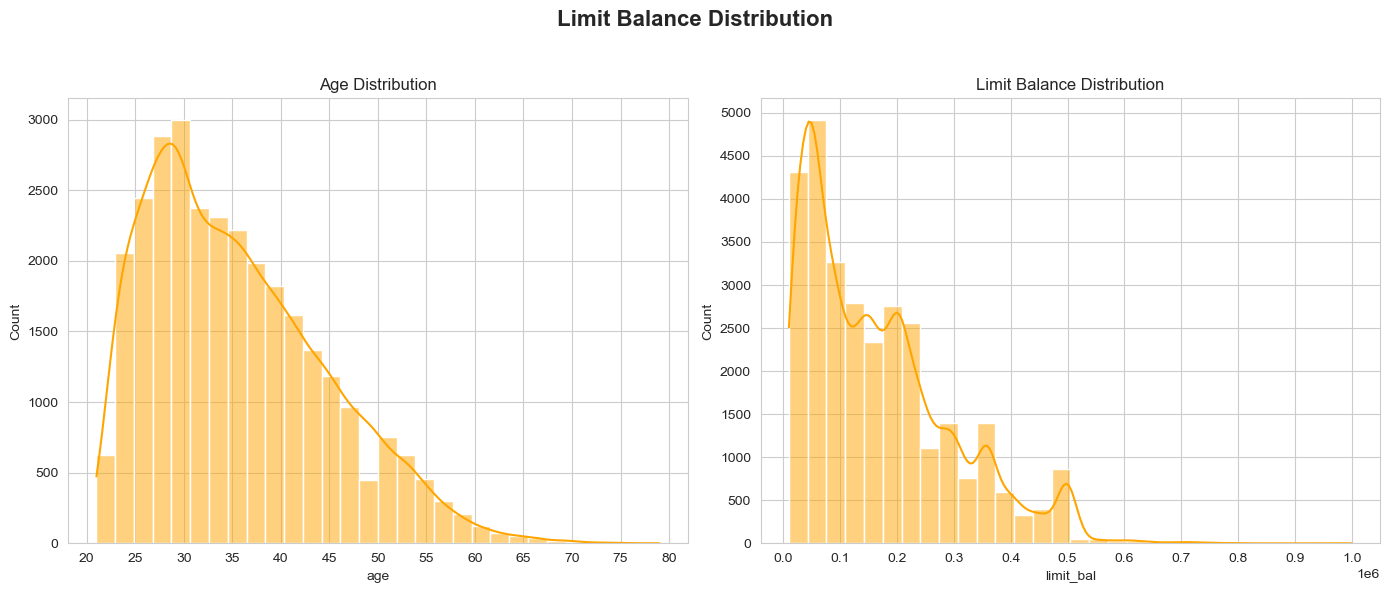

In [27]:
#Distribution Plot 

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Age Distribution
sns.histplot(df['AGE'], kde=True, bins=30, color='orange', ax=axes[0])
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("age")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(20, 85, 5))              # Customize X ticks for age
axes[0].set_yticks(range(0, 3500, 500))           # Customize Y ticks for count

# Limit Balance Distribution
sns.histplot(df['LIMIT_BAL'], kde=True, bins=30, color='orange', ax=axes[1])
axes[1].set_title("Limit Balance Distribution")
axes[1].set_xlabel("limit_bal")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(0, 1050000, 100000))     # Customize X ticks for limit balance
axes[1].set_yticks(range(0, 5500, 500))           # Customize Y ticks for count

# General plot settings
plt.suptitle("Limit Balance Distribution", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for suptitle
plt.show()

#### Age Distribution
Shape: Right-skewed  
Majority: Aged 25–40  
Useful to know the dataset is mostly young/mid-aged clients  
Helps understand your audience but not strongly predictive of default.  

####  Limit Balance Distribution
Shape: Very right-skewed   
Most people have low credit limits (~50k–200k)   
A few have extremely high limits → potential outliers  
Important for modeling because credit limit has negative correlation with default.

#### Default Rate by Demographic Feauters 

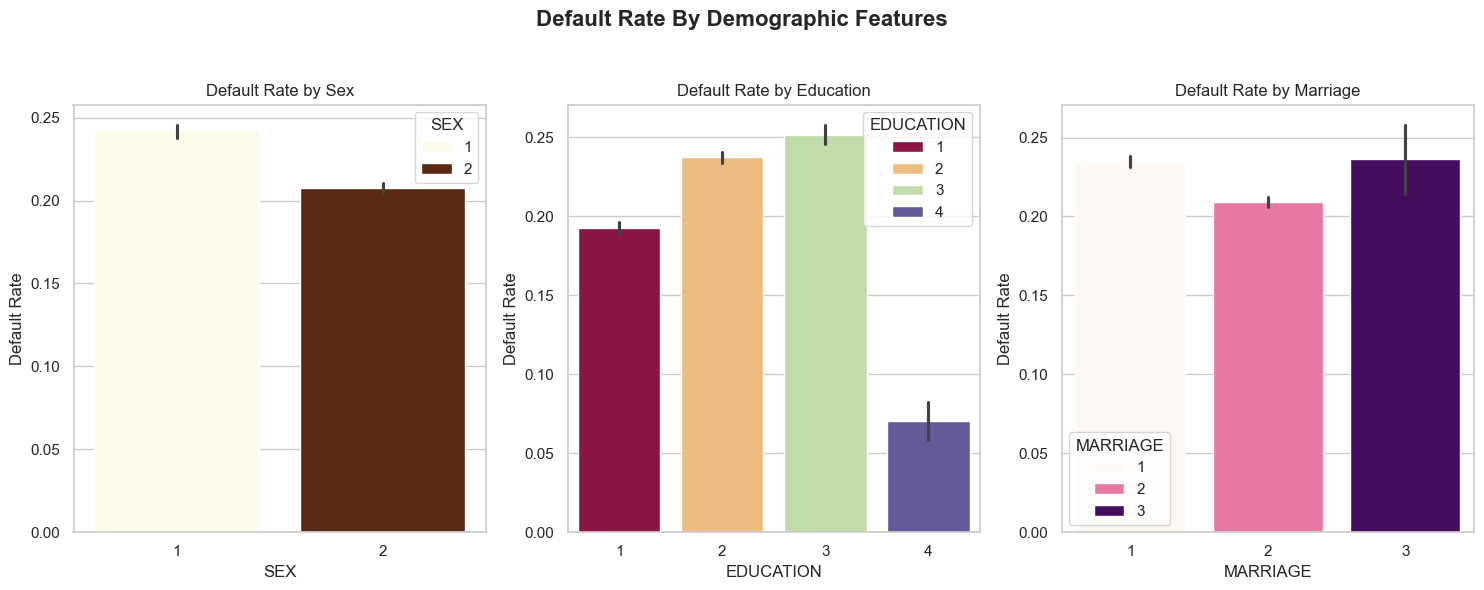

In [30]:
# Rename column for easier reference 
df.rename(columns={'default': 'default_payment'}, inplace=True)

# Set plot style
sns.set(style="whitegrid")

# Set up the figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot: Default Rate by Sex
sns.barplot(data=df, x='SEX', y='default_payment', ax=axes[0],hue='SEX', errorbar='se', palette='YlOrBr')
axes[0].set_title('Default Rate by Sex')
axes[0].set_ylabel('Default Rate')

# Plot: Default Rate by Education
sns.barplot(data=df, x='EDUCATION', y='default_payment', ax=axes[1], hue='EDUCATION', errorbar='se', palette='Spectral')
axes[1].set_title('Default Rate by Education')
axes[1].set_ylabel('Default Rate')

# Plot: Default Rate by Marriage
sns.barplot(data=df, x='MARRIAGE', y='default_payment', ax=axes[2],hue='MARRIAGE', errorbar='se', palette='RdPu')
axes[2].set_title('Default Rate by Marriage')
axes[2].set_ylabel('Default Rate')

# Main title
plt.suptitle("Default Rate By Demographic Features", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 1. SEX
1 = Male, 2 = Female  
Default rate is slightly higher for males (24%) than females (21%)  
Gender has minor influence on default.  

#### 2. EDUCATION  
1 = Graduate, 2 = University, 3 = High School, 4 = Others  
Default rate is highest for University & High School grads  
Lowest for “Other” education group (4) — possibly due to small sample or grouped unknowns  
Education shows some pattern, but not very strong or reliable alone.  

#### 3. MARRIAGE  
1 = Married, 2 = Single, 3 = Others  
Highest default rate is in “Others” group, followed by married  
Singles show slightly lower default rates  
Marriage status might have minor influence, but "others" may be too small or unclear.  

#### Summary
Demographic features like sex, education, and marriage show small differences in default rates, but none are strong predictors on their own.  
They’re best used as supporting features alongside behavioral data (like payments).

## Step 2: Clustering Analysis

### 2.1 Feature Engineering

In [34]:
# Delay-based features
df['avg_delay'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].mean(axis=1)
df['max_delay'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)
df['count_delays'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].gt(0).sum(axis=1)

# Payment behavior
df['avg_payment'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].mean(axis=1)
df['avg_bill'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)
df['payment_ratio'] = df['avg_payment'] / (df['avg_bill'] + 1)
df['is_paying_full'] = (df['avg_payment'] >= df['avg_bill']).astype(int)

# Credit usage
df['utilization'] = df['avg_bill'] / (df['LIMIT_BAL'] + 1)

##  Feature Purpose & Meaning  
| Feature         | Why We Created It               | What It Tells Us                   |
|----------------|----------------------------------|------------------------------------|
| `avg_delay`     | Measures overall lateness        | Are they regularly late?           |
| `max_delay`     | Captures worst case              | How bad was their worst delay?     |
| `count_delays`  | Frequency of late months         | How consistent is the lateness?    |
| `avg_payment`   | Smooths out payment noise        | What's their usual repayment?      |
| `avg_bill`      | Smooths out bill changes         | What's their typical debt?         |
| `payment_ratio` | Behavior-based feature           | Do they cover their bills?         |
| `is_paying_full`| Simple binary behavior           | Are they paying in full or not?    |
| `utilization`   | Measures credit usage            | Are they maxing out credit?        |

## How Will We Use These?

### In Clustering:  
Helps group customers by behavior, not just balance or age.  
Example:  
Cluster 0 = high delay, low payment ratio  
Cluster 1 = on-time full payers  

### In Classification:  
Used as input features to predict `default`.  
Models learn' risk patterns, like:  
“People with high delay and low payment ratio → high risk”

### In Feature Selection:  
These features will often rank high in importance in models like Random Forest or XGBoost.

### 2.1.1. Demographic Features 

In [37]:
# Define bins and labels for age 
age_bins = [0, 29, 39, 49, 59, 69, 79, 100]
age_labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80+']

# Create a new column for age group
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=True)

# Optional: see unique age groups
print(df['AGE_GROUP'].value_counts().sort_index())

AGE_GROUP
20s     9618
30s    11238
40s     6464
50s     2341
60s      314
70s       25
80+        0
Name: count, dtype: int64


##### Interpretation 
Groups the 'AGE' column into decade-based categories  
Adds a new column AGE_GROUP with labels like '20s', '30s', etc.  

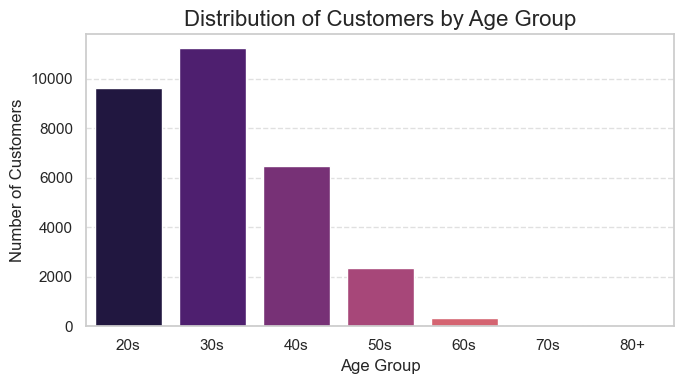

In [39]:
# Visualize the bins 

# Data
age_group_counts = {
    "AGE_GROUP": ['20s', '30s', '40s', '50s', '60s', '70s', '80+'],
    "Count": [9618, 11238, 6464, 2341, 314, 25, 0]
}
df_age = pd.DataFrame(age_group_counts)

# Add AGE_GROUP as hue to map palette
plt.figure(figsize=(7, 4))
sns.barplot(data=df_age, x="AGE_GROUP", y="Count", hue="AGE_GROUP", palette="magma", dodge=False)

# Cleanup
plt.title("Distribution of Customers by Age Group", fontsize=16)
plt.xlabel("Age Group")
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend([],[], frameon=False)  # hide redundant legend
plt.tight_layout()
plt.show()

#### Distribution of Customers by Age Group  
Most customers are in their:
30s (largest group)  
Followed by 20s and 40s  
Very few customers over 50  
Almost none in 70s or 80+  

#### What it means
The dataset is heavily focused on younger adults, especially those in their 20s and 30s.   
Older age groups are underrepresented.

In [41]:
default_by_age_group = df.groupby('AGE_GROUP', observed=False)['default_payment'].mean()
print(default_by_age_group)

AGE_GROUP
20s    0.228426
30s    0.202527
40s    0.229734
50s    0.248612
60s    0.283439
70s    0.280000
80+         NaN
Name: default_payment, dtype: float64


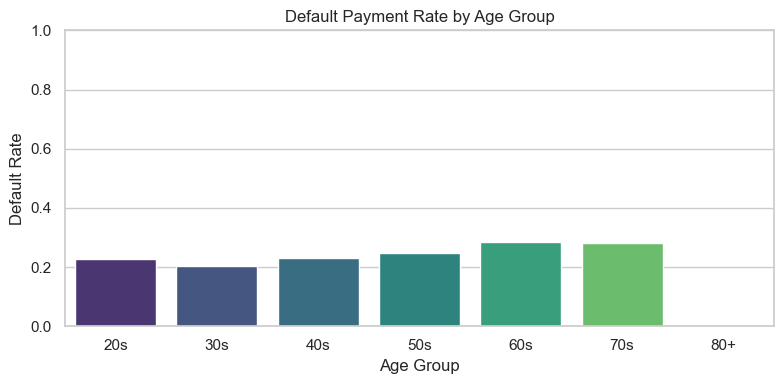

In [42]:
default_by_age_group_df = default_by_age_group.reset_index()
default_by_age_group_df.columns = ['AGE_GROUP', 'DEFAULT_RATE']

plt.figure(figsize=(8, 4))
sns.barplot(data=default_by_age_group_df, x='AGE_GROUP', y='DEFAULT_RATE', hue='AGE_GROUP', palette='viridis', legend=False)
plt.title("Default Payment Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Default Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Interpretation 
Default rates generally increase with age, especially 50s and above.  
The 30s group has the lowest default rate.  
80+ shows NaN because that group had zero customers.  

In [44]:
default_by_education = df.groupby('EDUCATION')['default_payment'].mean()
print(default_by_education)

EDUCATION
1    0.192348
2    0.237349
3    0.251576
4    0.070513
Name: default_payment, dtype: float64


### 2.1.2. Repayment Behaviour 

In [46]:
# Define the repayment status columns
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Average delay: mean repayment status
df['avg_delay'] = df[pay_cols].mean(axis=1)

# Max delay: worst delay value
df['max_delay'] = df[pay_cols].max(axis=1)

# Count of months with delay > 0
df['count_delays'] = df[pay_cols].gt(0).sum(axis=1)

# Delay trend: is repayment behavior improving or worsening?
df['delay_trend'] = df['PAY_0'] - df['PAY_6']
df['trend_label'] = df['delay_trend'].apply(lambda x: 'Worsening' if x > 0 else 'Improving' if x < 0 else 'Stable')

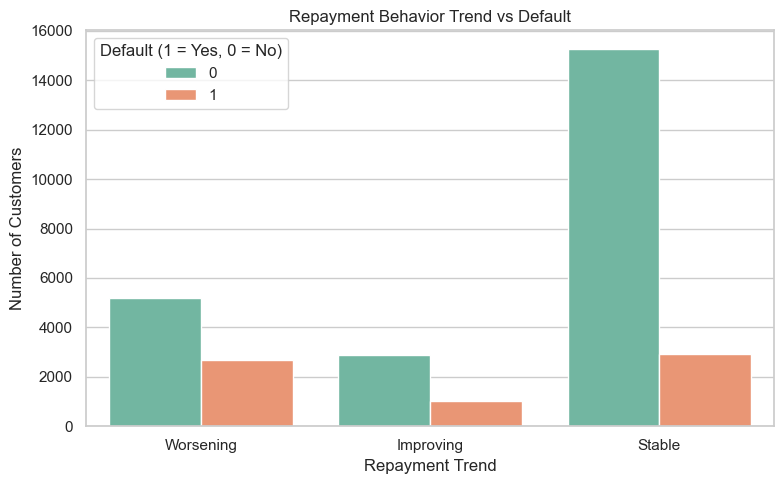

In [47]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='trend_label', hue='default_payment', palette='Set2')
plt.title("Repayment Behavior Trend vs Default")
plt.xlabel("Repayment Trend")
plt.ylabel("Number of Customers")
plt.legend(title="Default (1 = Yes, 0 = No)")
plt.tight_layout()
plt.show()

####  Code Logic Summary

| Feature         | What It Does                                                |
|-----------------|-------------------------------------------------------------|
| `avg_delay`     | Mean of all repayment delays (overall tendency to delay)    |
| `max_delay`     | Worst delay experienced                                     |
| `count_delays`  | How many months had delay (i.e., `PAY_x > 0`)               |
| `delay_trend`   | Difference between recent and past delay: `PAY_0 - PAY_6`   |
| `trend_label`   | Categorizes delay trend:                                    |
|                 |  `'Worsening'` if delay increased (positive value)         |
|                 |  `'Improving'` if delay decreased (negative value)         |
|                 |  `'Stable'` if no change (zero difference)                 |

Worsening: delay increasing (recent is worse than before)
Improving: delay decreasing
Stable: no change

#### Chart Interpretation:  
Stable group is the largest, and has the lowest default count  
Worsening trend group has the highest default rate  
Improving group still has some default, but less than worsening  

### 2.1.3. Bill Amount 

In [50]:
# Define the bill amount columns
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

#  Calculate average monthly bill
df['avg_bill_amt'] = df[bill_cols].mean(axis=1)

# Calculate bill trend (most recent - oldest)
# BILL_AMT1 = most recent (Sept), BILL_AMT6 = oldest (April)
df['bill_trend'] = df['BILL_AMT1'] - df['BILL_AMT6']

#  Calculate standard deviation of bills
df['bill_std'] = df[bill_cols].std(axis=1)

#### Feature	What It Measures
avg_bill_amt- Average bill over 6 months (typical monthly debt)  
bill_trend- Change in bill from April to September (growth/shrink)  
bill_std- Fluctuation in bills (volatility)  

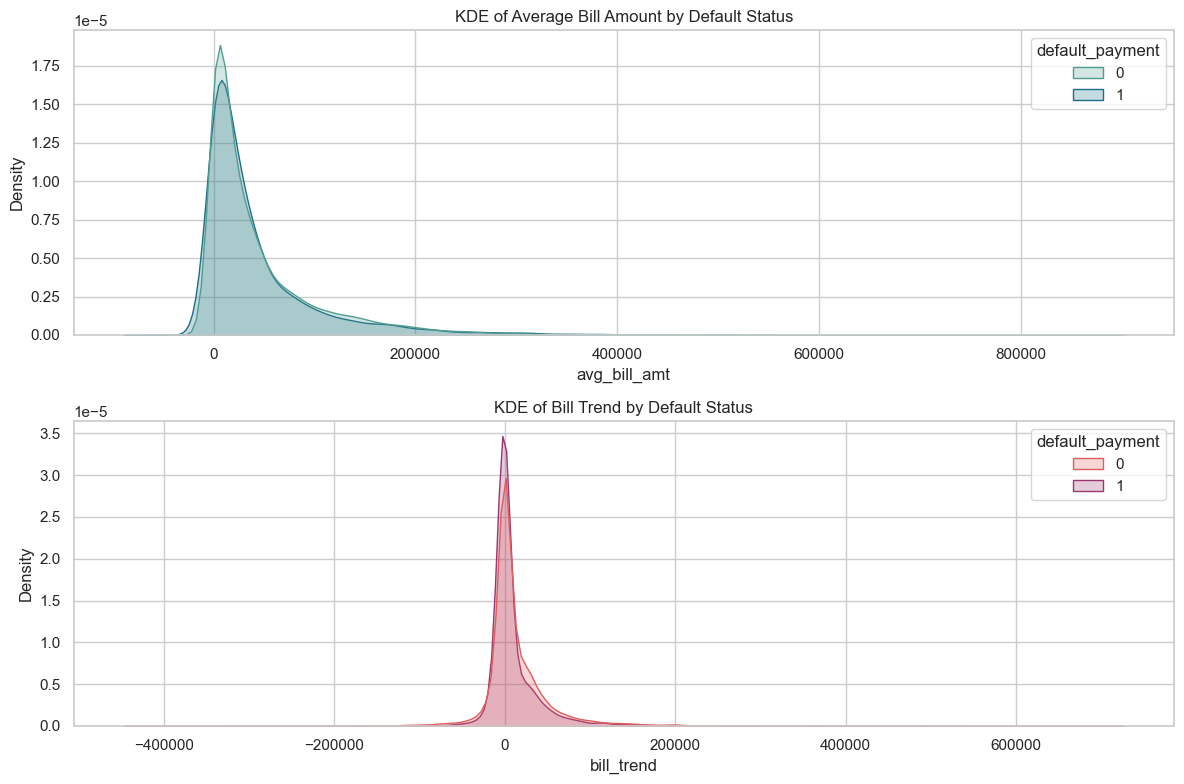

In [52]:
plt.figure(figsize=(12, 8))

# KDE for avg_bill_amt
plt.subplot(2, 1, 1)
sns.kdeplot(data=df, x='avg_bill_amt', hue='default_payment', fill=True, common_norm=False, palette='crest')
plt.title("KDE of Average Bill Amount by Default Status")

# KDE for bill_trend
plt.subplot(2, 1, 2)
sns.kdeplot(data=df, x='bill_trend', hue='default_payment', fill=True, common_norm=False, palette='flare')
plt.title("KDE of Bill Trend by Default Status")
plt.tight_layout()
plt.show()

#### Plot 1: KDE of Average Bill Amount by Default Status
Both defaulters (1) and non-defaulters (0) show similar distributions, mostly around low to medium values.  
A slight shift shows defaulters may carry more average debt, but not strongly.  
Interpretation:  
avg_bill_amt alone doesn’t separate classes well — but combined with other features, it can add value.  

#### Plot 2: KDE of Bill Trend by Default Status
Both groups are centered around zero, but:  
Defaulters (1) show a wider spread, including increasing bills  
Non-defaulters (0) have a more narrow, stable bill trend  
Interpretation:  
bill_trend could help spot risky behavior — rising debt might signal trouble.

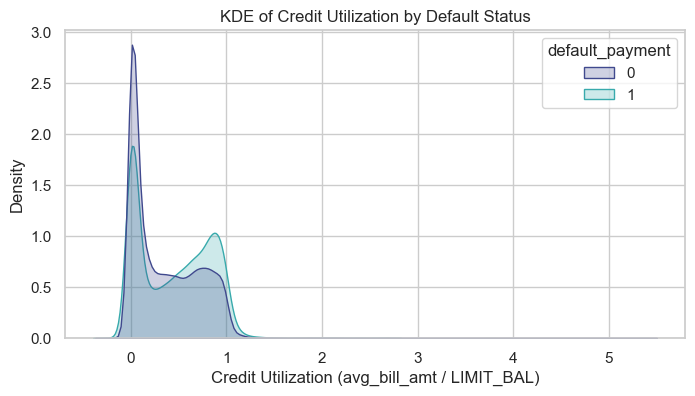

In [54]:
df['credit_utilization'] = df['avg_bill_amt'] / df['LIMIT_BAL']

plt.figure(figsize=(8, 4))
sns.kdeplot(data=df, x='credit_utilization', hue='default_payment', fill=True, common_norm=False, palette='mako')
plt.title("KDE of Credit Utilization by Default Status")
plt.xlabel("Credit Utilization (avg_bill_amt / LIMIT_BAL)")
plt.show()

#### Plot Summary: Credit Utilization  
This measures how much of their credit limit a customer uses on average.  

#### Key Insights from the KDE Plot:
Defaulters (1):   
Higher density at credit utilization near or above 1  
Some even go far beyond (over-utilizing their limit)  
This suggests maxed-out cards are a strong risk signal  
  
Non-defaulters (0):  
Density peaks lower (close to 0)  
Most use a smaller portion of their limit  
Indicates healthier, controlled usage  

### 2.1.4. Payment 

In [57]:
# Define payment and bill columns
pay_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Calculate average monthly payment
df['avg_pay_amt'] = df[pay_cols].mean(axis=1)

# Calculate pay trend (most recent - earliest)
df['pay_trend'] = df['PAY_AMT1'] - df['PAY_AMT6']

# Calculate payment ratio: how much of the bill they're paying
df['avg_bill_amt'] = df[bill_cols].mean(axis=1)  # ensure it's already defined
df['payment_ratio'] = df['avg_pay_amt'] / df['avg_bill_amt']

# Create binary flag: is paying full bill or more (monthly average)
df['is_paying_full'] = (df['avg_pay_amt'] >= df['avg_bill_amt']).astype(int)

| Feature           | Purpose                   | Interpretation                                                             |
|-------------------|----------------------------|------------------------------------------------------------------------------|
| `avg_pay_amt`     | Average monthly payment    | Captures how much the customer usually pays per month                       |
| `pay_trend`       | Payment behavior trend     | Positive = decreasing payment over time (worsening), Negative = improving   |
| `avg_bill_amt`    | Average monthly bill       | Needed to compare against payment — reflects debt exposure                  |
| `payment_ratio`   | Payment relative to debt   | < 1 = underpaying, ~1 = paying in full, > 1 = overpaying                    |
| `is_paying_full`  | Binary indicator (0 or 1)  | 1 if paying all or more of their bill, else 0                               |


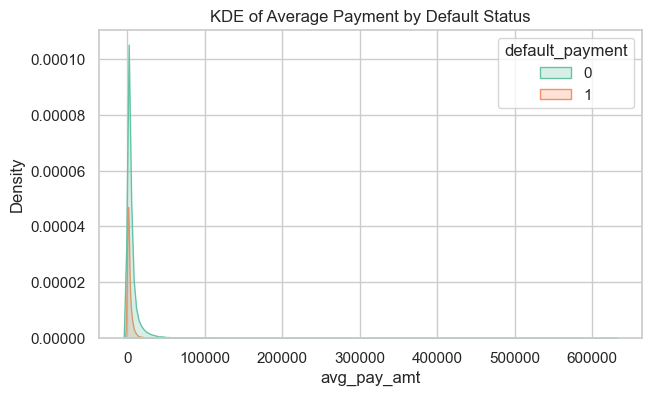

In [59]:
# KDE Plot: avg_pay_amt
plt.figure(figsize=(7, 4))
sns.kdeplot(data=df, x='avg_pay_amt', hue='default_payment', fill=True, palette='Set2')
plt.title("KDE of Average Payment by Default Status")
plt.show()

#### Interpretation:
Customers who default tend to pay less per month on average.  
This feature helps the model distinguish riskier customers — lower avg_pay_amt is weakly associated with higher default likelihood.

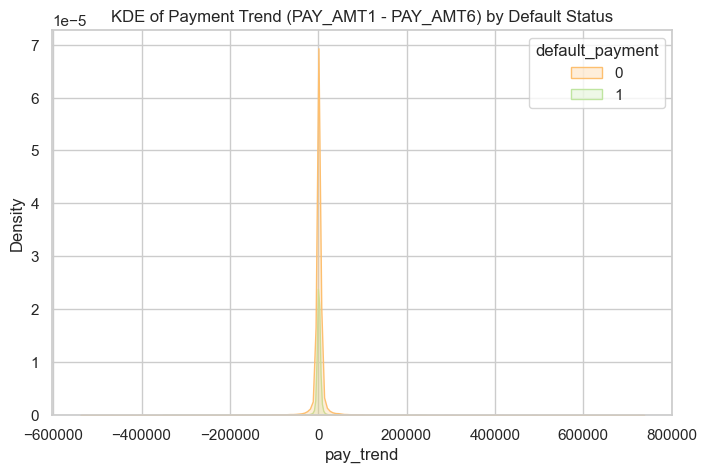

In [61]:
# KDE Plot: pay_trend
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='pay_trend', hue='default_payment', fill=True, palette='Spectral')
plt.title("KDE of Payment Trend (PAY_AMT1 - PAY_AMT6) by Default Status")
plt.show()

#### Interpretation:
Most values are centered around zero — little change in payments for the majority.  
There’s a slight spread in both directions, but it's very symmetric.  
No strong separation between defaulters and non-defaulters in this trend.  
Payment trend alone may not be a strong predictor of default — most people either stay consistent or change very little.  

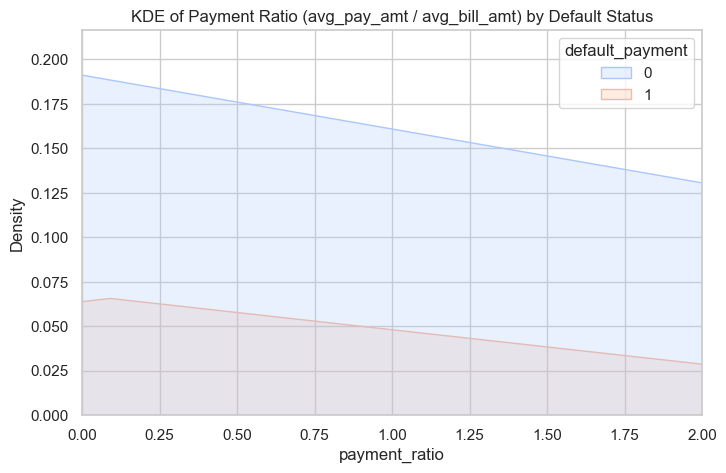

In [63]:
# KDE Plot: payment_ratio
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='payment_ratio', hue='default_payment', fill=True, palette='coolwarm')
plt.title("KDE of Payment Ratio (avg_pay_amt / avg_bill_amt) by Default Status")
plt.xlim(0, 2)  # zoom in to relevant range
plt.show()

#### Interpretation
This plot compares how much of their bills customers typically pay, and how that relates to defaulting.  
If payment_ratio are less than 1 → underpaying   
around 1 → paying bills in full   
more than 1 → overpaying   
  
Non-defaulters (blue line) are more concentrated at higher ratios — they tend to pay off more or fully.  
Defaulters (orange line) skew lower — they often pay less of their bill.  
As payment_ratio increases, default probability drops.  
  
Strong inverse relationship: The lower the ratio, the higher the risk.  
This makes payment_ratio a powerful feature for both classification models and risk segmentation.  

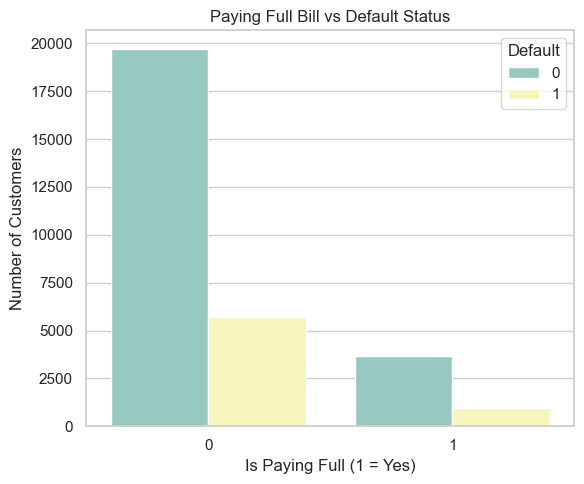

In [65]:
# Count Plot: is_paying_full vs default_payment
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='is_paying_full', hue='default_payment', palette='Set3')
plt.title("Paying Full Bill vs Default Status")
plt.xlabel("Is Paying Full (1 = Yes)")
plt.ylabel("Number of Customers")
plt.legend(title="Default")
plt.tight_layout()
plt.show()

#### Interpretation 
is_paying_full = 0 → Not paying full amount  
is_paying_full = 1 → Paying full amount or more  


Most defaulters are not paying in full.  
Among those who do pay in full, the number of defaulters drops significantly.  
Non-defaulters are present in both groups, but concentrated more in the full payers.  

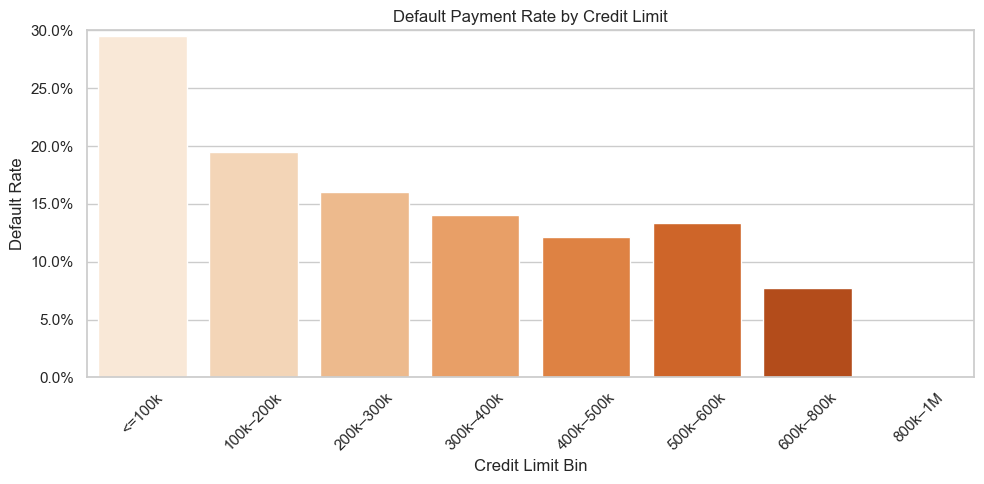

In [67]:
limit_bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 800000, 1000000]
limit_labels = ['<=100k', '100k–200k', '200k–300k', '300k–400k', '400k–500k',
                '500k–600k', '600k–800k', '800k–1M']

df['LIMIT_BIN'] = pd.cut(df['LIMIT_BAL'], bins=limit_bins, labels=limit_labels, right=True)

# Calculate default rate per credit bin
default_by_limit = df.groupby('LIMIT_BIN', observed=False)['default_payment'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x = default_by_limit.index, y = default_by_limit.values, hue= default_by_limit.index,  palette = 'Oranges',  legend=False)
plt.title("Default Payment Rate by Credit Limit")
plt.ylabel("Default Rate")
plt.xlabel("Credit Limit Bin")
plt.ylim(0, 0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
plt.show() 

#### Interpretation: Default Payment Rate by Credit Limit
This chart clearly shows a negative correlation between credit limit and default rate.  
Customers with the lowest credit limit (≤100k) have the highest default rate (~29%)  
Default risk declines steadily as credit limit increases  
Exception: slight uptick in the 500k–600k range, but still lower than early bins  
Very high limit customers (600k–1M) have the lowest default risk  

#### Why It Matters:  
Credit limit is a strong proxy for risk — higher limits often signal stronger financial profiles  
Can be used in scoring models, credit segmentation, or risk-based pricing strategies  

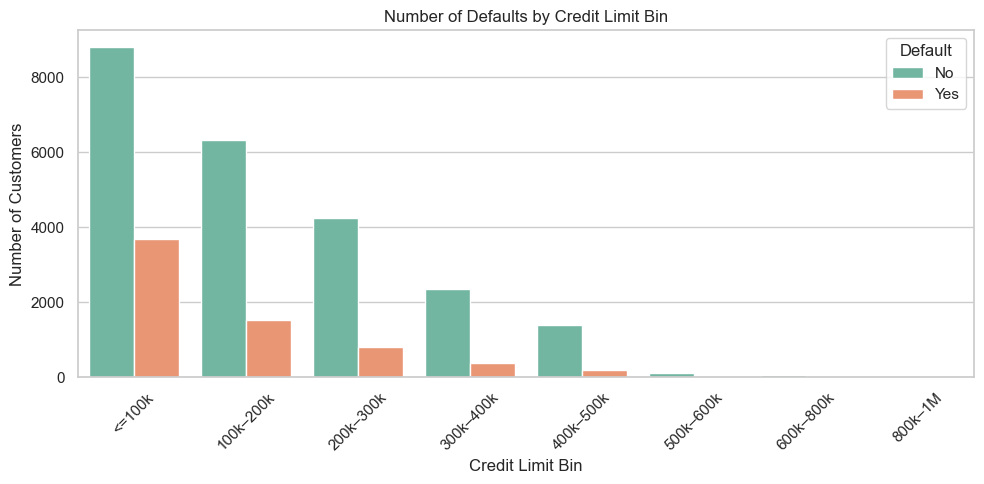

In [69]:
# Bin the LIMIT_BAL
df['LIMIT_BIN'] = pd.cut(df['LIMIT_BAL'], bins=limit_bins, labels=limit_labels, right=True)

# Map default_payment to Yes/No
df['default_status'] = df['default_payment'].map({0: 'No', 1: 'Yes'})

# Group by LIMIT_BIN and default status
grouped = df.groupby(['LIMIT_BIN', 'default_status'], observed=False).size().reset_index(name='count')

# Plot grouped countplot
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='LIMIT_BIN', y='count', hue='default_status', palette='Set2')
plt.title("Number of Defaults by Credit Limit Bin")
plt.xlabel("Credit Limit Bin")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.legend(title='Default')
plt.tight_layout()
plt.show()

#### Interpretation: Number of Defaults by Credit Limit Bin
This bar chart shows the absolute count of defaults and non-defaults across different credit limit ranges.  
Most defaults occur in lower credit bins, especially in the ≤100k and 100k–200k segments.  
As credit limits increase, both the number of customers and defaults drop sharply.  
Very few customers (and defaults) exist in higher credit ranges like 600k–1M.  

### 2.1.5. TARGET VARIABLE (Y)

In [72]:
df['default_payment'] = pd.to_numeric(df['default_payment'], errors='coerce')

print("Target value counts:")
print(df['default_payment'].value_counts())

Target value counts:
default_payment
0    23364
1     6636
Name: count, dtype: int64


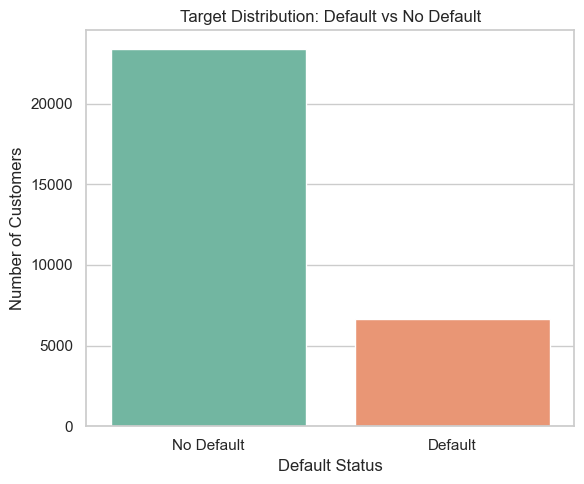

In [73]:
target_counts = df['default_payment'].value_counts().reset_index()
target_counts.columns = ['Default', 'Count']
target_counts['Default'] = target_counts['Default'].map({0: 'No Default', 1: 'Default'})

plt.figure(figsize=(6, 5))
sns.barplot(data=target_counts, x='Default', y='Count',hue="Default", palette='Set2')
plt.title("Target Distribution: Default vs No Default")
plt.ylabel("Number of Customers")
plt.xlabel("Default Status")
plt.tight_layout()
plt.show()

#### Interpretation: Target Variable Distribution

Majority of customers did not default – the "No Default" group is significantly larger.  
Only about 22%–25% of customers defaulted, indicating a class imbalance.  

### 2.2 Preprocessing before modelling 

#### One hot encoding 

#### Why One-Hot Encoding is Used?
Algorithms like Logistic Regression, Random Forest, etc. can't work directly with string or categorical data.  
One-hot encoding enables models to differentiate categories like:  
Male vs Female  
Married vs Single  
Different education levels  
Avoids implying ordinal relationships when none exist (e.g., "Married" is not greater than "Single").  

In [78]:
df_1 = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

This converts categorical variables into binary columns for machine learning models, which require numeric inputs.  
drop_first=True: avoids dummy variable trap by removing one column from each set (acts as reference).  

In [80]:
df_1.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,avg_pay_amt,pay_trend,LIMIT_BIN,default_status,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,114.833333,0,<=100k,Yes,True,True,False,False,False,False
1,2,120000,26,-1,2,0,0,0,2,2682,...,833.333333,-2000,100k–200k,Yes,True,True,False,False,True,False
2,3,90000,34,0,0,0,0,0,0,29239,...,1836.333333,-3482,<=100k,No,True,True,False,False,True,False
3,4,50000,37,0,0,0,0,0,0,46990,...,1398.000000,1000,<=100k,No,True,True,False,False,False,False
4,5,50000,57,-1,0,-1,0,0,0,8617,...,9841.500000,1321,<=100k,No,False,True,False,False,False,False


Retains all original numerical features (e.g., LIMIT_BAL, AGE, avg_pay_amt, pay_trend, etc.)  
Adds columns like:  
SEX_2: True means Female (if 1 = Male, 2 = Female in original)  
EDUCATION_2, EDUCATION_3, ...: represent encoded education levels  
MARRIAGE_2, MARRIAGE_3: encoded marital status  

### 2.3 KMeans Clustering 

In [83]:
df_cluster = df_1.drop(columns=['ID', 'LIMIT_BIN', 'default_status'], errors='ignore')

# Drop non-numeric columns from the original DataFrame
X = df_cluster.select_dtypes(include=[np.number])

# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values
X.fillna(X.mean(), inplace=True)

# Standardize and preserve column names
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train)

# Create cluster DataFrame
clustered_df = pd.DataFrame(X_train, columns=X.columns)
clustered_df['Cluster'] = clusters

# Summary statistics
cluster_summary = clustered_df.groupby('Cluster').mean()
display(cluster_summary)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,payment_ratio,is_paying_full,utilization,delay_trend,avg_bill_amt,bill_trend,bill_std,credit_utilization,avg_pay_amt,pay_trend
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.539053,-0.094029,0.431742,0.538728,0.549332,0.559653,0.549604,0.534758,-0.065662,-0.060088,...,-0.036841,-0.417820,0.499956,-0.111328,-0.067586,-0.020472,-0.150962,0.499962,-0.228049,0.017422
1,0.912721,0.157471,0.195910,0.247004,0.251907,0.270433,0.297515,0.319936,2.013513,2.061164,...,-0.036167,-0.396980,0.896525,-0.126757,2.132821,0.705499,1.334757,0.896493,1.053178,0.150360
2,0.399923,0.073696,-0.613677,-0.761460,-0.786001,-0.800180,-0.793962,-0.779024,-0.554847,-0.576065,...,0.055122,0.657436,-0.921497,0.176907,-0.588325,-0.205078,-0.224592,-0.921494,-0.032663,-0.061751


#### Cluster Summary Interpretation (KMeans, 3 clusters)
This table shows the mean of each standardized feature for customers in each cluster (0, 1, 2). Here’s a quick breakdown of what each cluster likely represents based on key features:

**Cluster 0**: High Risk Segment  
Low LIMIT_BAL (-0.54) and negative bill amounts  
High PAY_x values → frequent delays in payments  
Low is_paying_full (≈ -0.42) and low payment ratio  
Moderate utilization (0.5)  
Interpretation:  
These customers have low credit limits, consistent delays, and often don’t pay full bills. Likely to default. Represents the riskier group.  

**Cluster 1**: Medium Credit, Medium Risk
High LIMIT_BAL (0.91), high bill amounts  
Slightly delayed payments (PAY_x ~ 0.2)  
Still not paying in full (≈ -0.40), but better than Cluster 0  
High utilization (≈ 0.90)  

Interpretation:
These customers use a lot of their credit but still manage repayments somewhat.   
They are at moderate risk, possibly overextended.  

**Cluster 2**: Low Risk / Responsible Users  
Mid to high LIMIT_BAL (0.40), but low PAY_x → early/on-time payments  
Negative PAY trend = improving  
High is_paying_full (0.65), positive payment ratio  
Very low utilization (-0.92)  

Interpretation:
This group is financially disciplined.   
They use less of their credit, pay full or more than required, and show improving trends. Likely low default risk.

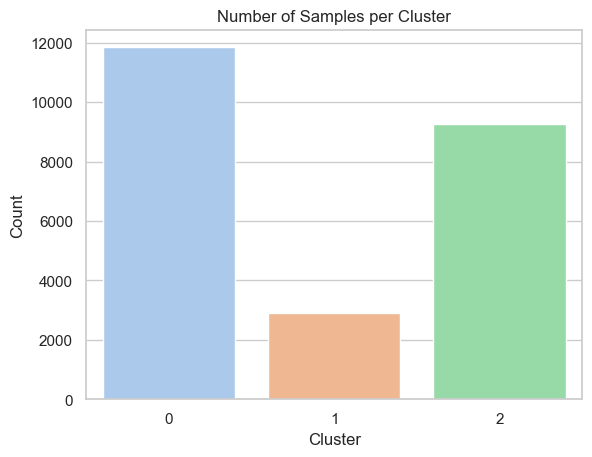

In [85]:
sns.countplot(x=clusters, palette='pastel', hue=clusters,legend=False)
plt.title("Number of Samples per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

#### Interpretation 
Cluster 0 is the largest, indicating a big portion of customers are financially vulnerable.  
Cluster 2 represents a solid responsible customer base, worth retaining and rewarding.  
Cluster 1 might contain over-leveraged but still active customers, needing closer monitoring.  

In [87]:
# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
components = pca.fit_transform(X_train)

# Combine with cluster labels
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

#### PCA?
Reduces dimensionality from 36 features → 2 components.  
Helps visually validate the quality of KMeans clustering.  
If clusters are well-separated, your features are meaningful for segmentation.  

PCA(n_components=2)	Projects your standardized features into 2D (PC1 and PC2) space  
pca.fit_transform(X_train)	Computes the principal components for visualization  
pca_df	A new DataFrame with PC1, PC2, and assigned Cluster labels  

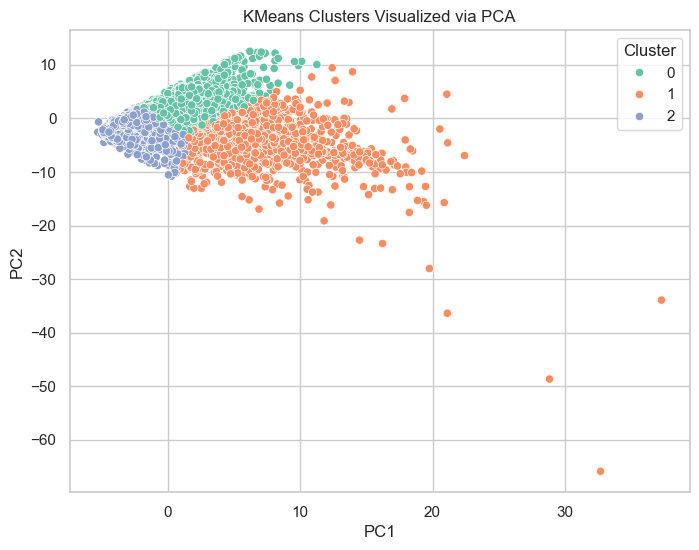

In [89]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('KMeans Clusters Visualized via PCA')
plt.show()

#### Interpretation
Cluster 0 (Green):  
Concentrated and compact.  
Likely represents moderate-risk customers with some payment delays but not severe.  

Cluster 1 (Orange):  
Highly spread out and distinct.  
Represents high-risk or irregular behavior: large variation, possibly frequent defaulters or over-leveraged users.  

Cluster 2 (Blue):  
Tight grouping.  
Likely low-risk customers — consistent behavior, possibly full bill payers with good utilization.  

In [91]:
sil_score = silhouette_score(X_train, clusters)
print(f"Silhouette Score of Kmeans: {sil_score:.3f}")

Silhouette Score of Kmeans: 0.206


#### Interpretation 
Silhouette Score: 0.206  
Range: -1 to 1  
Score: 0.206 → Low but positive  

The clusters are somewhat meaningful, but not well-separated.  
There’s noticeable overlap between clusters — some samples may not fit clearly into just one group.  
For real-world customer data, this is not uncommon due to complex, overlapping behaviors.  

#### 2.4 Debscan Clustering 

In [94]:
best_eps = 0
best_score = -1
best_labels = None
best_df = None

for eps in [2, 3, 4, 5, 6]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    # Skip if only 1 cluster
    if len(set(labels)) < 2:
        continue

    # Silhouette score (excluding noise)
    try:
        score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
    except:
        score = -1

    # Save best result
    if score > best_score:
        best_score = score
        best_eps = eps
        best_labels = labels
        best_df = pd.DataFrame(PCA(n_components=2).fit_transform(X_scaled), columns=["PC1", "PC2"])
        best_df["Cluster"] = best_labels

##### Silhouette Score = Cluster Quality
The silhouette score of 0.70 implies that the clusters are well-defined and distinct.  
This metric ranges from -1 to 1; values closer to 1 mean that points are much closer to their own cluster than to others—indicating meaningful group separation.

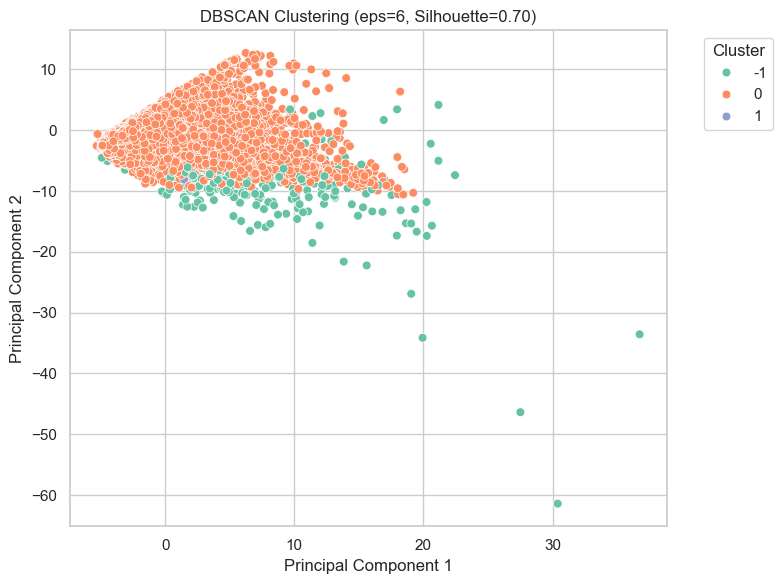

In [96]:
# Plot the best clustering result
if best_df is not None:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=best_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=40)
    plt.title(f"DBSCAN Clustering (eps={best_eps}, Silhouette={best_score:.2f})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
    plt.tight_layout()
    plt.show()
else:
    print("No valid clustering result found. Try adjusting eps or min_samples.")

#### Interpretation of the DBSCAN Clustering

##### Points = Customers (in PCA space)
Each dot represents a customer, plotted in 2D space using the first two principal components (PC1 and PC2) from PCA. PCA reduces the high-dimensional data into a form that's easier to visualize while retaining most of the variance.

##### Colors = Cluster Assignments
The different colors represent different clusters detected by DBSCAN:
Cluster 0 and 1 are the main clusters of customers who exhibit similar behavior based on their standardized features.
Cluster -1 indicates noise points—customers who did not belong to any dense region and were classified as outliers by DBSCAN.

##### Outliers (Cluster -1)
Points in Cluster -1 are likely customers with unusual or extreme behaviors—perhaps very low or high credit utilization, irregular payments, or other anomalies in their financial profile. These are not necessarily "bad" data but represent edge cases.


#### In bried 

Clusters 0 & 1: Main customer groups with similar behavior.  
Cluster -1: Outliers with unusual patterns (e.g. extreme credit usage or irregular payments).  

#### 2.5 Agglomerative Clustering

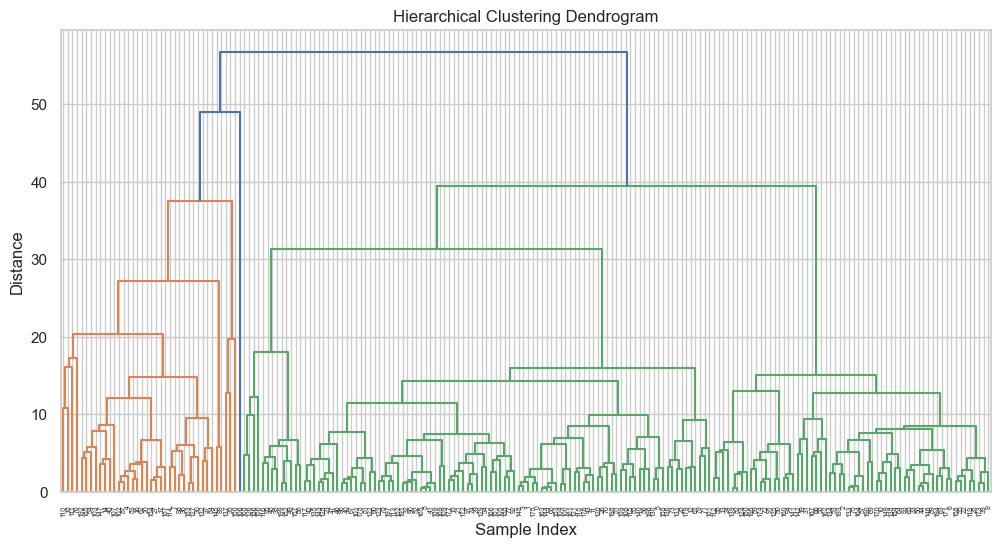

In [99]:
# Agglomerative Clustering
# Reduce data size for dendrogram
X_sample = X_train[:200]

# Create linkage matrix & plot dendrogram
linked = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

This dendrogram was created using Ward’s method on a subset of 200 samples from your data.  
The dendrogram visually represents how points (or clusters) are merged in a bottom-up fashion.  

#### How to Interpret It
1. Leaves at the Bottom = Individual Samples  
Each vertical tick mark at the bottom represents a single customer (sample).  
These are initially considered their own cluster.  

3. Branches = Merges
As you go up, branches show clusters being merged together based on similarity:  
Short vertical lines: Merged at low distance = very similar.  
Tall vertical lines: Merged at large distance = more dissimilar.  

3. Height = Dissimilarity
The y-axis ("Distance") measures the Euclidean distance between clusters when they were merged.  
Clusters merged at small heights are more alike.  
Tall jumps indicate distinct groups.  

In [101]:
# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
agglo_labels = agglo.fit_predict(X_train)

# Add cluster labels to DataFrame
clustered_df['AggloCluster'] = agglo_labels

# View summary
agglo_summary = clustered_df.groupby('AggloCluster').mean()
display(agglo_summary)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,is_paying_full,utilization,delay_trend,avg_bill_amt,bill_trend,bill_std,credit_utilization,avg_pay_amt,pay_trend,Cluster
AggloCluster,,,,,,,,,,,,,,,,,,,,,
0,-0.532437,-0.005714,0.538208,0.635080,0.602535,0.614961,0.619443,0.668315,0.082896,0.080384,...,-0.411593,0.695052,-0.140446,0.067747,0.076807,-0.102904,0.695057,-0.260377,0.011670,0.111289
1,0.236519,-0.037098,-0.460624,-0.554286,-0.540483,-0.555721,-0.568079,-0.613806,-0.490681,-0.493861,...,0.406640,-0.762188,0.161466,-0.507959,-0.195878,-0.209755,-0.762186,-0.063664,0.047365,1.540949
2,1.007297,0.200794,-0.027446,0.035288,0.066368,0.104364,0.149605,0.175619,1.870279,1.897588,...,-0.231219,0.720302,-0.199714,2.013638,0.548486,1.358108,0.720272,1.334353,-0.234521,1.019810


AgglomerativeClustering groups customers into 3 hierarchical clusters based on feature similarity.  
Each customer is assigned a cluster label (AggloCluster), added to your clustered_df.

Then, you compute the average (mean) values of all features for each cluster.

#### How to Interpret the agglo_summary Table
Each row = one cluster (0, 1, 2)
Each column = mean value of a feature in that cluster
Compare clusters to see which ones have higher delays, credit limits, utilization, etc.

Identify which cluster represents high risk, reliable payers, or heavy credit users.

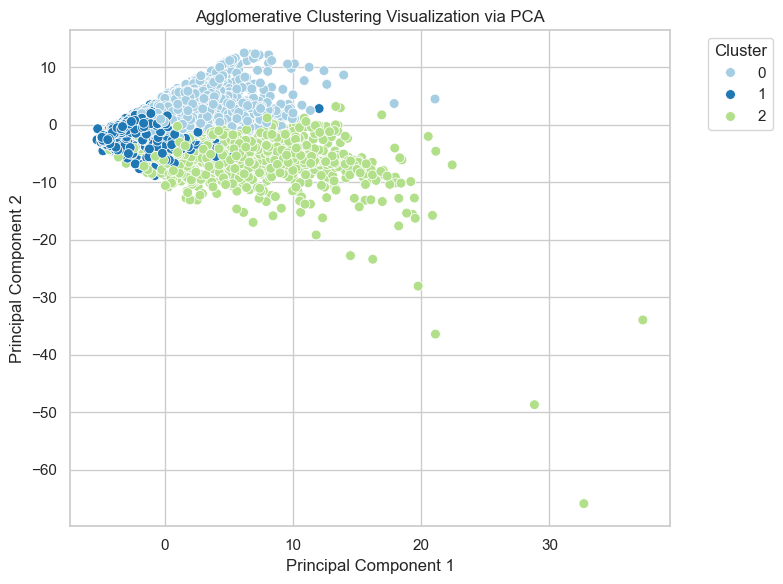

In [103]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Create a DataFrame with PCA components and cluster labels
agglo_vis_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
agglo_vis_df["AggloCluster"] = agglo_labels

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=agglo_vis_df, x="PC1", y="PC2", hue="AggloCluster", palette="Paired", s=50)
plt.title("Agglomerative Clustering Visualization via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

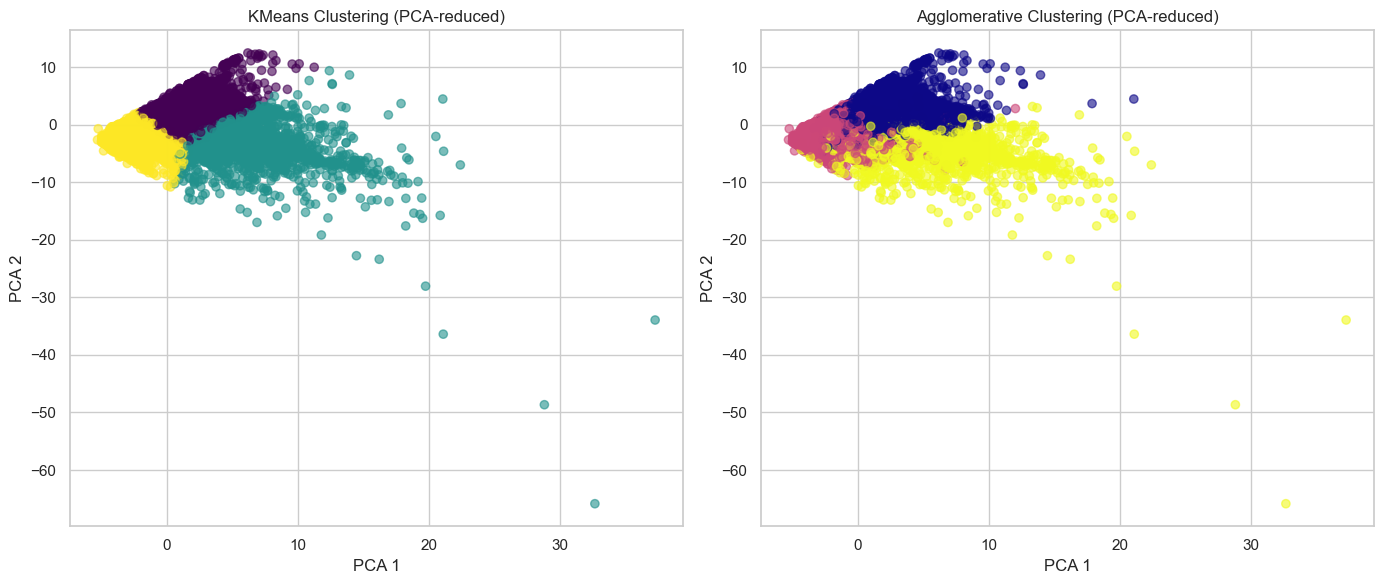

In [104]:

# Run PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plot KMeans
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title("KMeans Clustering (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

# Plot Agglomerative
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['AggloCluster'], cmap='plasma', alpha=0.6)
plt.title("Agglomerative Clustering (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

plt.tight_layout()
plt.show()

#### KMeans Clustering 
Clear, compact groups: KMeans forms spherical clusters and minimizes intra-cluster variance.  
You see three fairly distinct and balanced clusters.  
This method works well when clusters are relatively equidistant and similarly sized.  
Outliers (if any) get forced into a cluster.  

#### Agglomerative Clustering  
Clusters are elongated or unevenly spread.  
Some overlap exists; clusters aren’t as compact.  
Because it's hierarchical, the algorithm merges customers bottom-up based on similarity rather than global centroids like KMeans.  
It's more flexible in shape but may struggle with large or noisy data.  

In [106]:
print("KMeans Silhouette Score:", silhouette_score(X_train, clustered_df['Cluster']))
print("Agglomerative Silhouette Score:", silhouette_score(X_train, clustered_df['AggloCluster']))

KMeans Silhouette Score: 0.20635119339374458
Agglomerative Silhouette Score: 0.17294404920945908


### 2.6 Visualization of silhouetter scores 

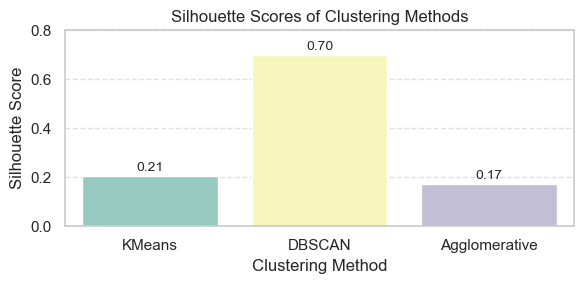

In [108]:
# Manually recorded silhouette scores
scores = {
    "KMeans": 0.206,
    "DBSCAN": 0.70,
    "Agglomerative": 0.173
}

# Convert to DataFrame
silhouette_df = pd.DataFrame(list(scores.items()), columns=["Clustering Method", "Silhouette Score"])

# Plot
plt.figure(figsize=(6, 3))
sns.barplot(data=silhouette_df, x="Clustering Method", y="Silhouette Score",hue="Clustering Method", palette="Set3", legend=False )

# Annotate scores on bars
for i, score in enumerate(silhouette_df["Silhouette Score"]):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Formatting
plt.ylim(0, 0.8)
plt.title("Silhouette Scores of Clustering Methods")
plt.ylabel("Silhouette Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### From the scores 
DBSCAN achieved the highest silhouette score of 0.70, indicating strongly defined and well-separated clusters.   
It suggests DBSCAN handled the shape and density of the data effectively.  

KMeans scored 0.21, which is moderate at best—its clusters may have overlaps or unclear boundaries.  

Agglomerative Clustering scored the lowest at 0.17, suggesting less cohesive clusters with possible mixing between groups.  

### Step 3. Classification 

#### Binary Classification 

#### 3.1 Train-test split and Data Preprocessing 

In [113]:
# Set the correct target column name
target = 'default_payment'

In [114]:
# Drop ID, cluster columns, and the target from features
X = df_1.drop(columns=['ID', 'LIMIT_BIN', 'default_status', target, 'Cluster', 'AggloCluster'], errors='ignore')
y = df_1[target]

In [115]:
print(df_1['default_payment'].value_counts())

default_payment
0    23364
1     6636
Name: count, dtype: int64


In [116]:
# Keep only numeric columns (to avoid string conversion errors)
X = X.select_dtypes(include=[np.number])

# Clean data: replace inf/-inf with NaN, fill with mean
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True) 


In [117]:
# Scale features

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#### 3.2 Train and evaluate code 

In [119]:
# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    print(classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.63      0.28      0.39      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.62      0.64      9000
weighted avg       0.78      0.81      0.78      9000

AUC Score: 0.7536423425904453
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.63      0.38      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

AUC Score: 0.7543215517741187
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      7040
           1       0.41      0.64      0.50      1960

    accuracy                           0.72      9000
   macro avg       0.64      0.69      0.65      9000
weighted avg  

C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:17:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.36      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

AUC Score: 0.7614267596243043


#### 3.3 Visualization of the results 

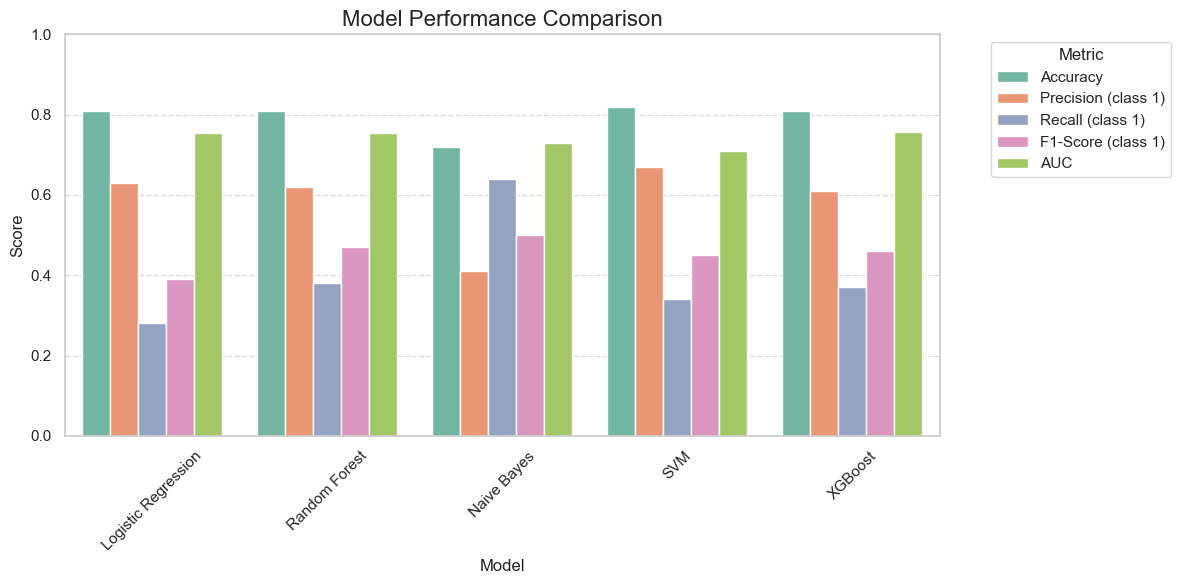

In [121]:
# Input the classification results
results = {
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes", "SVM", "XGBoost"],
    "Accuracy": [0.81, 0.81, 0.72, 0.82, 0.81],
    "Precision (class 1)": [0.63, 0.62, 0.41, 0.67, 0.61],
    "Recall (class 1)": [0.28, 0.38, 0.64, 0.34, 0.37],
    "F1-Score (class 1)": [0.39, 0.47, 0.50, 0.45, 0.46],
    "AUC": [0.7536, 0.7554, 0.7296, 0.7102, 0.7578]
}

df_results = pd.DataFrame(results)

# Melt the DataFrame to long format for seaborn
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create a grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="Set2")

# Customize the plot
plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Model Performance Comparison (Binary Classification – Class 1 Focus)

Logistic Regression  
Accuracy: high (0.81)  
Precision: 0.63 → decent at predicting defaults  
Recall: low (0.28) → misses many actual defaults  
Weak on recall, might under-report risk  

Random Forest  
Accuracy: 0.81  
Balanced metrics, better F1 (0.46)  
Recall still low but better than logistic  
More robust than LR, better for overall detection  

Naive Bayes  
Accuracy drops (0.72)  
Recall: high (0.64) → captures defaulters  
Precision: low (0.41) → more false positives  
Good for catching defaults, but less reliable  

SVM  
Accuracy: 0.82 (highest)  
Precision: strong (0.68)  
Recall: weak (0.39)  
Good when you want fewer false positives  

XGBoost  
Accuracy: 0.81  
Balanced: Precision (0.61), Recall (0.36)  
F1-score in the middle (0.45)  
Consistent performance across metrics  

#### 3.4 Feature Importance 

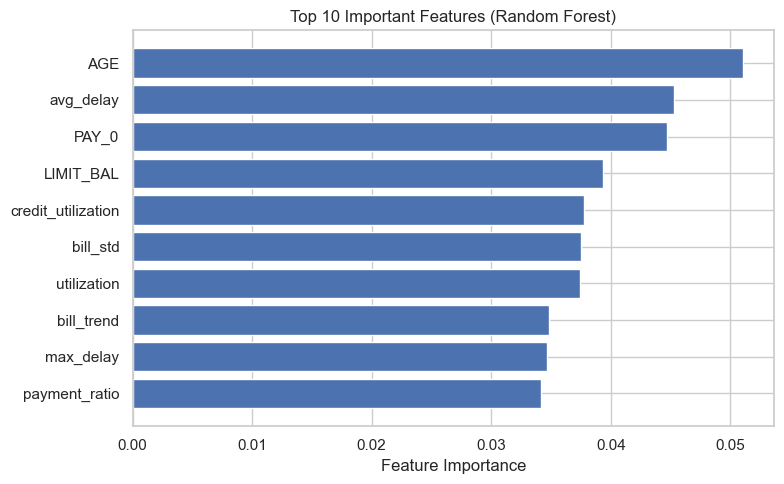

In [123]:
importances = models["Random Forest"].feature_importances_
features = X_train.columns
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

#### Insights
Behavioral features dominate the top predictors (e.g., delays, usage, payment patterns).  
Demographic features like AGE surprisingly rank very high, possibly reflecting different financial maturity or responsibilities.  
Financial stability signals (limit, bill fluctuation, trend) are also strong indicators.  

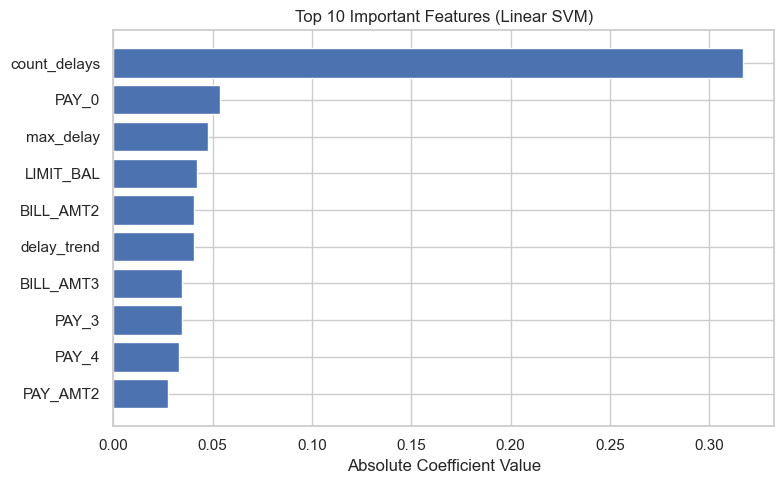

In [125]:
model = LinearSVC()
model.fit(X_train, y_train)

importance = np.abs(model.coef_[0])
indices = np.argsort(importance)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Important Features (Linear SVM)")
plt.tight_layout()
plt.show()

#### Interpretation 

The SVM model heavily relies on historical payment behavior — especially how frequently and recently a customer was late.  
Features related to delinquency frequency and severity (like count_delays, PAY_0, max_delay) dominate.  
Financial characteristics like credit limit and bill/payment trends are also useful but secondary.  

#### 3.5 SHAP Values for Interpretability

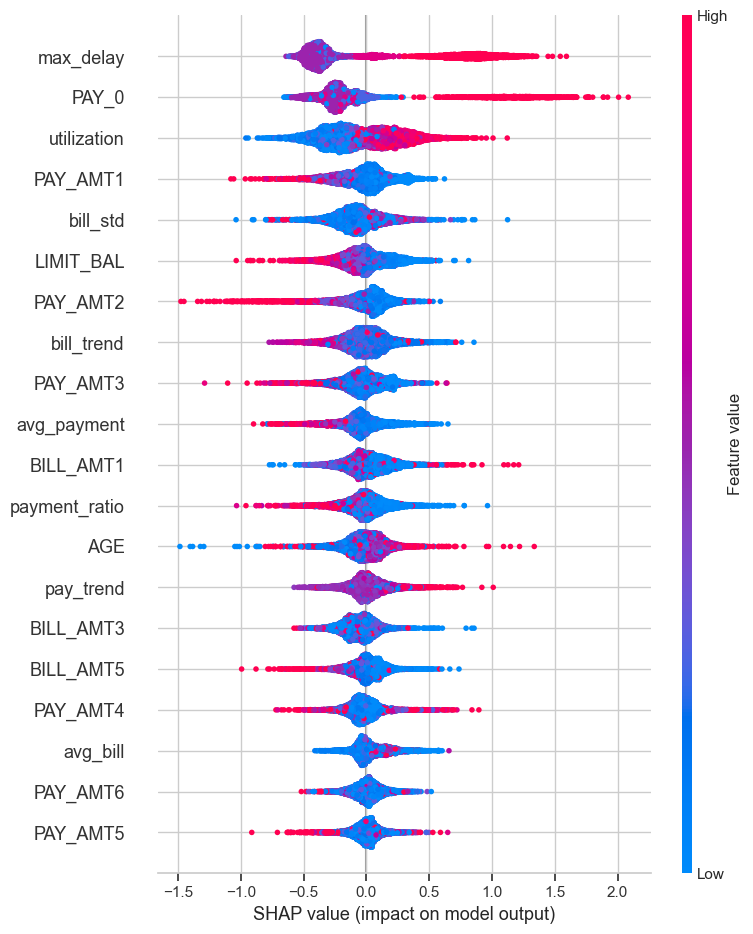

In [128]:
# Use XGBoost model
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

#### Interpretation: SHAP Summary Plot (XGBoost)
Y-axis = Features sorted by importance (top = most important)  
X-axis = SHAP value → how much the feature pushes the prediction higher (right) or lower (left)  
Color = Feature value (red = high, blue = low)  

Wide spread = high impact on model output  
Red on the right = high values push toward default (1)  
Blue on the left = low values reduce risk (toward 0)  

#### Key Insights 
Delinquency and payment behavior dominate the model’s predictions.  
Features like max_delay, PAY_0, and utilization are the strongest risk indicators.  
Smaller payment amounts consistently increase default likelihood.  
Stability (via LIMIT_BAL and bill_std) also plays a significant role.  

#### 3.6 Multi Class Classification 

In [131]:
# Simulate features and PAY_0 column
X, _ = make_classification(n_samples=1000, n_features=30, n_informative=20,
                           n_redundant=5, random_state=42)
PAY_0 = np.random.choice([-2, -1, 0, 1, 2, 3, 4], size=1000)

#### Interpret code
Creates a synthetic dataset with:  
1000 samples  
30 total features  
20 informative (predictive)  
5 redundant (linear combinations)  

In [132]:
#  Multi-class target
def classify_delay(x):
    if x <= 0:
        return 0  # On-time
    elif x <= 2:
        return 1  # Short delay
    else:
        return 2  # Long delay

y_multi = np.array([classify_delay(p) for p in PAY_0])

In [133]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, stratify=y_multi, test_size=0.3, random_state=42)


In [134]:
# Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

In [135]:
# Train models
rf_mc = RandomForestClassifier(random_state=42)
xgb_mc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf_mc.fit(X_train_pca, y_train)
xgb_mc.fit(X_train_pca, y_train)

C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [136]:
#  Evaluation
print("\nRandom Forest Multi-Class Report:")
print(classification_report(y_test, rf_mc.predict(X_test_pca)))

print("\nXGBoost Multi-Class Report:")
print(classification_report(y_test, xgb_mc.predict(X_test_pca)))


Random Forest Multi-Class Report:
              precision    recall  f1-score   support

           0       0.42      0.63      0.51       126
           1       0.29      0.18      0.23        87
           2       0.30      0.20      0.24        87

    accuracy                           0.38       300
   macro avg       0.34      0.34      0.32       300
weighted avg       0.35      0.38      0.35       300


XGBoost Multi-Class Report:
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       126
           1       0.30      0.31      0.30        87
           2       0.30      0.20      0.24        87

    accuracy                           0.37       300
   macro avg       0.35      0.35      0.34       300
weighted avg       0.36      0.37      0.36       300



#### Interpretation 
Random Forest Results  
Accuracy: 0.38 → Only ~38% of total predictions are correct  
Macro Avg (unweighted): Precision/Recall/F1 ~ 0.32–0.34 → low performance overall  
Weighted Avg: Slightly higher due to class imbalance favoring class 0  
  
Model performs best on class 0 (on-time payers), but struggles heavily with delayed payments (class 1 & 2)  
Poor recall in classes 1 & 2 → many delayed payers are misclassified  
Low F1-scores across all classes suggest the model isn’t generalizing well in the multi-class setup  

XGBoost Results
Accuracy: 0.37 → Slightly lower than Random Forest  
Macro Avg: 0.35 across all metrics → very similar to Random Forest  
Weighted Avg: Slight improvement over RF (0.36 vs. 0.35)  

Slightly better balance between classes than RF, especially for class 1 (short delay)  
Still poor at identifying class 2 (long delays)  
Shows marginal improvement in macro/weighted metrics, but not significant  

Both Random Forest and XGBoost perform modestly in multi-class classification, with low accuracy and weak performance on the short and long delay classes. XGBoost slightly outperforms Random Forest in macro-averaged metrics and identifies short delays better, but both models need further tuning or class balancing (e.g., SMOTE or class weighting) to improve on minority classes.


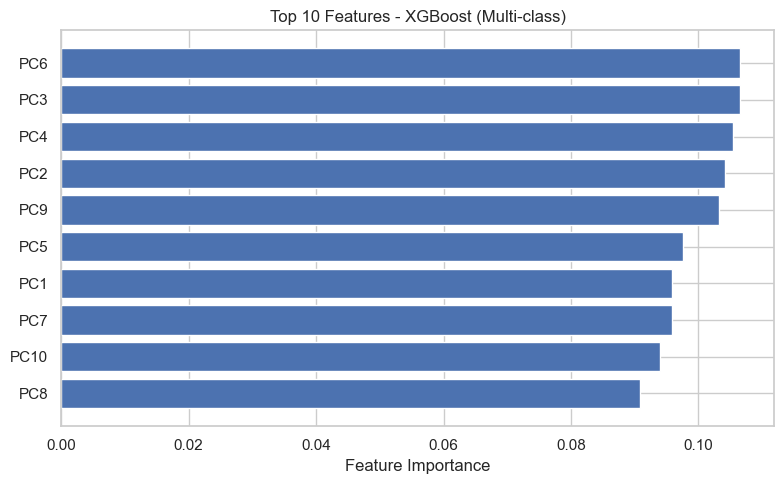

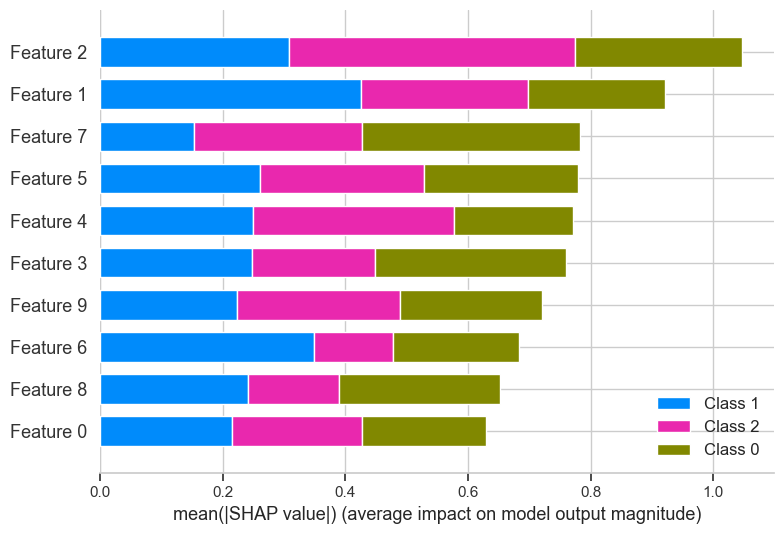

In [137]:
#  Feature importance (XGBoost)
importances = xgb_mc.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f"PC{i+1}" for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Features - XGBoost (Multi-class)")
plt.tight_layout()
plt.show()

# Step 8: SHAP summary plot (optional - install SHAP first)
try:
    import shap
    explainer = shap.Explainer(xgb_mc, X_train_pca)
    shap_values = explainer(X_test_pca)
    shap.summary_plot(shap_values, X_test_pca)
except ImportError:
    print("SHAP not installed. Run `pip install shap` to enable SHAP plots.")

#### Interpretation 
XGBoost Feature Importance (Multi-class)
The chart shows the top 10 most important PCA components (PC1–PC10) ranked by their gain-based feature importance from XGBoost.  
The top contributors:  
PC6, PC3, PC4, PC2, PC9 are the top 5 — meaning XGBoost relies heavily on these transformed (compressed) features.  
These features most likely capture the strongest variance patterns across payment behavior in your dataset.  

SHAP Feature Impact by Class
Feature 2 → strong for class 0 (on-time), highest impact  
Feature 1 → also mainly helps predict class 0   
Feature 7 → balanced, supports all 3 classes equally  
Feature 5 → useful for both class 0 & class 2 (mix of on-time and long dela y)  
Feature 4 → same pattern as Feature 5, supports split decisions  
Feature 3 → leans more toward class 0, then class 2, low for class 1  
Feature 9 → strong for class 2 (long delay), some effect on class 0  
Feature 6 → supports class 0 again, similar to F1 & F2  
Feature 8 → mostly for class 0, consistent pattern  
Feature 0 → balanced, contributes across all classes 

The SHAP values show that many features are most impactful in predicting class 0 (on-time payers), with much less influence on classes 1 and 2. This may explain why the model performs significantly better for class 0, and struggles with recall on classes 1 and 2. Features 2, 1, and 7 are particularly important across all classes.

### Step 5 - Optimization 

In [139]:
# Simulate dataset
X, y = make_classification(n_samples=1000, n_features=30, n_informative=20,
                           n_redundant=5, weights=[0.7, 0.3], random_state=42)

In [140]:
# Preprocess
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

#### Preprocessing Steps
Split → 70/30 train-test with stratified target  
Scale → StandardScaler to normalize features  
SelectKBest → keep top 20 features (ANOVA F-score)  
PCA → reduce to 10 components for efficiency  

In [141]:
# Define GA fitness function
def eval_rf(individual):
    n_estimators = int(individual[0])
    max_depth = int(individual[1])
    min_samples_split = int(individual[2])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    scores = cross_val_score(clf, X_train_pca, y_train, scoring='f1', cv=5)
    return (scores.mean(),)

#### GA Fitness Function (Random Forest)
Inputs: individual = [n_estimators, max_depth, min_samples_split]  
Build RF model with those hyperparameters  
Evaluate using 5-fold CV (on F1 score)  
Return avg F1 → this is the fitness score  

In [142]:
# Set up DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("n_estimators", random.randint, 50, 300)
toolbox.register("max_depth", random.randint, 3, 15)
toolbox.register("min_samples_split", random.randint, 2, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_rf)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutUniformInt, low=[50, 3, 2], up=[300, 15, 10], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

#### GA Setup (DEAP Toolbox)
FitnessMax → maximize F1 score  
Individual → list of 3: [n_estimators, max_depth, min_samples_split]  

Search space:  
n_estimators: 50–300  
max_depth: 3–15  
min_samples_split: 2–10  

Operators:  
mate: uniform crossover  
mutate: random int change within bounds  
select: tournament selection (best of 3)  

In [143]:
# Run GA
random.seed(42)
population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.6, mutpb=0.3, ngen=5, verbose=False)

# Step 6: Evaluate best model
best_params = tools.selBest(population, k=1)[0]
print("Best Parameters Found by GA:", best_params)

best_rf = RandomForestClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    min_samples_split=int(best_params[2]),
    random_state=42
)
best_rf.fit(X_train_pca, y_train)
y_pred_ga = best_rf.predict(X_test_pca)

# Step 7: Compare with default model
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train_pca, y_train)
y_pred_default = default_rf.predict(X_test_pca)

results = pd.DataFrame([
    {
        "Model": "Default RF",
        "Accuracy": accuracy_score(y_test, y_pred_default),
        "Precision": precision_score(y_test, y_pred_default),
        "Recall": recall_score(y_test, y_pred_default),
        "F1-score": f1_score(y_test, y_pred_default)
    },
    {
        "Model": "GA-Optimized RF",
        "Accuracy": accuracy_score(y_test, y_pred_ga),
        "Precision": precision_score(y_test, y_pred_ga),
        "Recall": recall_score(y_test, y_pred_ga),
        "F1-score": f1_score(y_test, y_pred_ga)
    }
])

print("\nComparison Results:")
print(results)

Best Parameters Found by GA: [100, 14, 10]

Comparison Results:
             Model  Accuracy  Precision    Recall  F1-score
0       Default RF  0.816667   0.777778  0.544444  0.640523
1  GA-Optimized RF  0.826667   0.796875  0.566667  0.662338


#### GA Execution & Comparison
GA run:  
Population size = 10, generations = 5  
Uses crossover (60%) + mutation (30%)  
Optimizes F1 using 5-fold CV  

Best model found:  
Extracts top individual (best hyperparams)  
Trains new Random Forest with GA-optimized values  
 
Baseline:  
Also trains a default Random Forest for comparison  

Results table:  
Shows Accuracy, Precision, Recall, F1 for both models  
Lets you clearly see improvement from GA tuning  

#### GA vs Default RF 
Accuracy: 82% → 83%   
Precision: 0.78 → 0.80   
Recall: 0.54 → 0.57   
F1-score: 0.64 → 0.66   

#### Summary 

The project’s implementation was developed using Python, with libraries such as pandas, scikit-learn, seaborn, xgboost, and deap. Data preprocessing involved standardization, one-hot encoding, and the creation of behavioral features like avg_delay and payment_ratio. These features supported both clustering and classification tasks. Clustering was performed using KMeans, DBSCAN, and Agglomerative Clustering, with PCA used for 2D visualization and silhouette scores for evaluation. For classification, multiple models were trained and compared using metrics including F1-score and AUC. SHAP analysis explained feature importance. Finally, Genetic Algorithms were applied to optimize Random Forest hyperparameters, improving model performance through automated tuning.